# Penguin Classifier - CROP

Based on fastai course notebooks from lessons 1 and 2


## Training a penguin classifier model

See also penguins-SQUISH

I tried some image transforms outside of the models - ie created a seperate starting point where all images are a square. 
* If the image was landscape - centre crop
* If the image was portrait - crop bottom up (so top of image remains)


In [1]:
from fastai.vision import *
from fastai.utils.mem import *
from fastai.utils import *
import torch
import gc

## Set up data

In [2]:
# images have already been cropped to a square (not resized)
path = Path('data/penguins_crop')

In [3]:
classes = ['adelie', 'african', 'chinstrap', 'emperor', 'erect_crested', 'fiordland', 'galapagos', 'gentoo', 'humboldt', 
           'king', 'little', 'macaroni', 'magellanic', 'rockhopper', 'royal', 'snares', 'yellow_eyed']

## Set up methods

In [4]:
# clean memory
def clean_memory():
    collect_result = gc.collect()
    torch.cuda.empty_cache()
    mem_use = gpu_mem_get()
    print('collected ' + collect_result + ' ' + str(mem_use))
    print('')
   

In [5]:
import functools, traceback
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

In [6]:
@gpu_mem_restore
def do_cycles(data, cycles, save_name):
    learn = cnn_learner(data, models.resnet34, metrics=error_rate)
    learn.fit_one_cycle(cycles)
    learn.save(save_name)
    return learn

@gpu_mem_restore
def do_lr_find(learn):
    learn.unfreeze()
    learn.lr_find()

## Now Train

In [10]:
# create data bunch - standard transforms
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), 
        size=244, bs=16, num_workers=4).normalize(imagenet_stats)

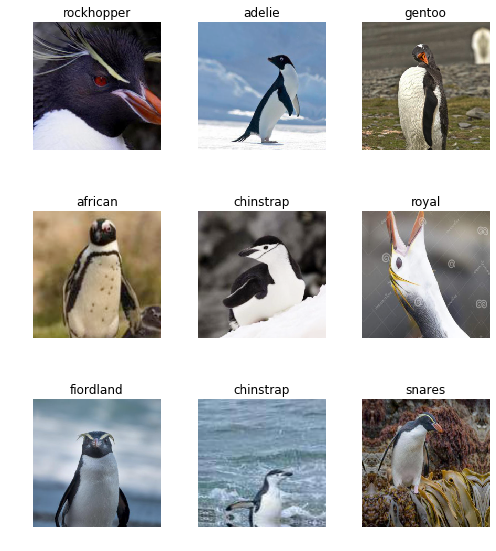

In [9]:
data.show_batch(rows=3, figsize=(7,8))

First train with 6 cycles

In [11]:
learn = do_cycles(data, 6, 'crop')

epoch,train_loss,valid_loss,error_rate,time
0,2.034625,1.057291,0.312839,00:54
1,1.222399,0.730599,0.235081,00:53
2,0.912239,0.652668,0.202532,00:51
3,0.703773,0.593494,0.195298,00:51
4,0.590762,0.550408,0.175407,00:51
5,0.517077,0.551248,0.177215,00:51


In [12]:
do_lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


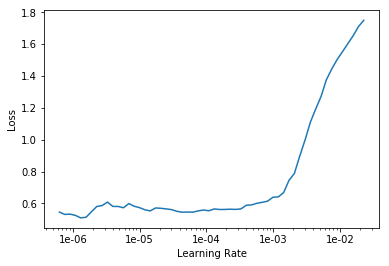

In [13]:
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(2, max_lr=slice(5e-5,5e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.759297,0.693972,0.207957,01:10
1,0.496046,0.445619,0.137432,01:05


In [15]:
# save the learner
learn.save('crop-lr')

## Interpretation

Lets look at the results

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

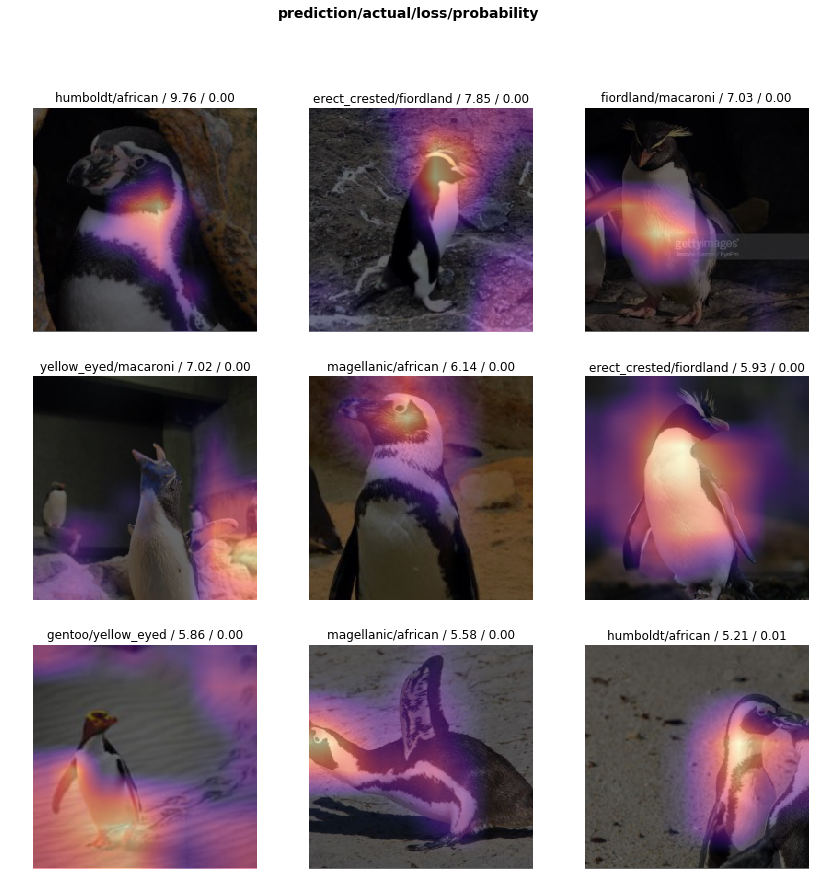

In [17]:
interp.plot_top_losses(9, figsize=(14,14))

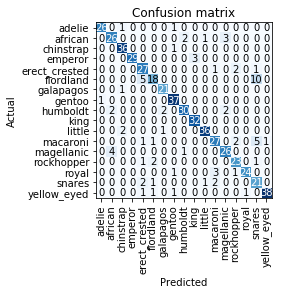

In [18]:
interp.plot_confusion_matrix()

In [19]:
interp.most_confused(min_val=2)

[('fiordland', 'snares', 10),
 ('fiordland', 'erect_crested', 5),
 ('macaroni', 'snares', 5),
 ('magellanic', 'african', 4),
 ('african', 'magellanic', 3),
 ('emperor', 'king', 3),
 ('royal', 'macaroni', 3),
 ('african', 'humboldt', 2),
 ('erect_crested', 'rockhopper', 2),
 ('humboldt', 'african', 2),
 ('humboldt', 'galapagos', 2),
 ('humboldt', 'magellanic', 2),
 ('little', 'chinstrap', 2),
 ('macaroni', 'rockhopper', 2),
 ('rockhopper', 'fiordland', 2),
 ('snares', 'erect_crested', 2),
 ('snares', 'macaroni', 2)]

The only surprising confusion in this run was little/chinstrap, otherwise as expected.

In [ ]:
# export the model
learn.freeze()
learn.export(destroy=True) 